# Vedant - Example

How to run contacts using the brahe library, with some additional functions in this repository!

First, make sure to install the brahe library:

```bash
pip install git+https://github.com/duncaneddy/brahe.git@master matplotlib ipympl cartopy
```

## Setup Imports

(not relevant to repo, can skip) 

Adding module path to run correctly in examples folder

In [1]:
import sys
import os


# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/vedantsrinivas/loc-gsopt/src


## Imports & Downloading latest Earth Orientation Data

In [2]:
from common.sat_gen import make_tle
from common.station_gen import teleport_json
from common.utils import load_earth_data, compute_all_gaps_contacts

# Brahe Imports
import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba
import numpy as np 
%matplotlib inline

import matplotlib.pyplot as plt

# Setup info
load_earth_data('data/iau2000A_finals_ab.txt')

Loading the latest Earth Orientation Data


## Generate Satellites Using TLEs

In [4]:
##### Trying to generate a satellite just through tles ######

# Create a TLE
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # This is the epoch of the orbital elements
alt  = 550 # Altitude in km
ecc  = 0.01 # Eccentricity - Generally don't want it to be 0, so give it a small value 0.0001 to 0.01
inc  = 53 # Inclination in degrees
raan = 15 # Right Ascension of the Ascending Node in degrees
argp = 30 # Argument of Perigee in degrees
M    = 45 # Mean Anomaly in degrees
norad_id = 99999 # NORAD ID of the satellite - This is just a placeholder, but we need a number.

tle = make_tle(epc0, alt, ecc, inc, raan, argp, M, norad_id=norad_id)

print(f'Our TLE looks like:\n {tle.line1}\n {tle.line2}\n')

sat1 = bdm.Spacecraft(
    id=99999, # Might need to change this at one point
    name="Sat1",
    line1=tle.line1,
    line2=tle.line2,
)

Our TLE looks like:
 1 99999U          24141.00000000  .00000000  00000-0  00000-0 0    00
 2 99999  53.0000  15.0000 0100000  30.0000  45.0000 15.05490874    07



## Load Ground Station Locations and Compute Contacts

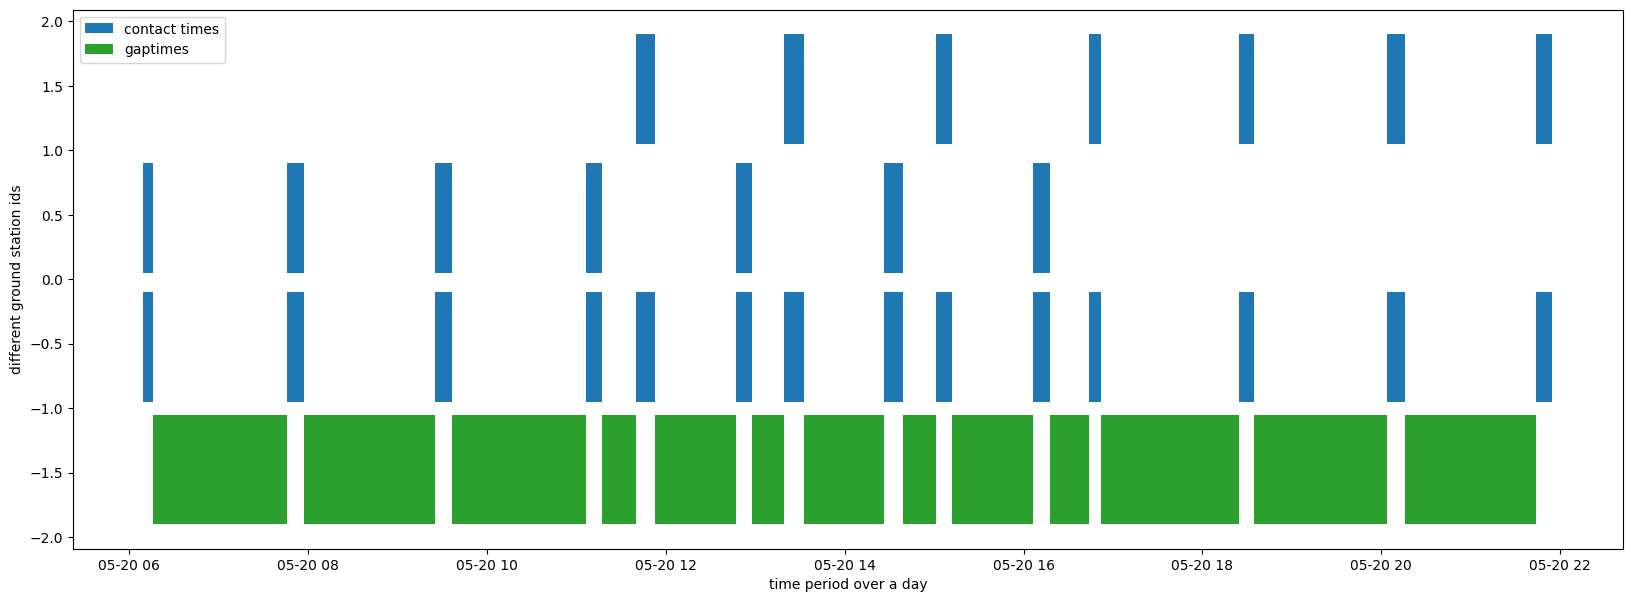

In [5]:
fig, ax = fig, ax =  plt.subplots(figsize=(20,7))

# Ground station Locations
stations = teleport_json('data/teleport_locations.json')

# Computing Contacts for only one day
epc1 = epc0 + 86400 # seconds in a day

contacts_all = []

######################## Plotting specific! ####################

# going through computing contacts for all stations and all 
for station,id in zip(stations[0:2],range(len(stations[0:2]))):
    contacts = ba.find_location_accesses(sat1,station,epc0,epc1)
    for contact in contacts:
        contacts_all.append(contact)
    ax.broken_barh([(contacts[i].t_start,contacts[i].t_end-contacts[i].t_start) for i in range(len(contacts))], (id+0.05, 0.85),facecolors='tab:blue')

ax.broken_barh([(contacts_all[i].t_start,contacts_all[i].t_end-contacts_all[i].t_start) for i in range(len(contacts_all))], (-0.95, 0.85),facecolors='tab:blue', label = "contact times")

sorted_contacts = sorted(contacts_all, key=lambda t: t.t_start)
all_gap_times = []

current_t_end = sorted_contacts[0].t_end
for contact in sorted_contacts:
    if current_t_end < contact.t_end and current_t_end > contact.t_start:
        current_t_end = contact.t_end
    if current_t_end < contact.t_start:
        all_gap_times.append((current_t_end,contact.t_start))
        current_t_end = contact.t_end

ax.broken_barh([(all_gap_times[i][0],all_gap_times[i][1]-all_gap_times[i][0]) for i in range(len(all_gap_times))], (-1.9, 0.85),facecolors='tab:green',label = "gaptimes")

plt.ylabel("different ground station ids")
plt.xlabel("time period over a day")
plt.legend()
plt.show()

######################## Plotting specific! ####################



### Just to see the gap times:

In [6]:
_, _, gaps_seconds = compute_all_gaps_contacts([sat1], stations[0:20] ,epc0, epc1, False)
print(gaps_seconds)

[4967.296453, 5039.893488, 5143.289483, 4977.351984, 5020.799249, 490.428168, 4041.651289, 12.378241, 363.613257, 2586.273505, 2622.958685, 2667.25556, 813.071576, 2618.104559, 1274.880359, 0.444947, 2472.433172, 1861.175537, 4916.35285, 4958.855291]


In [7]:
np.mean(gaps_seconds)

np.float64(2842.42538265)

In [10]:
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
import numpy as np
from common.utils import compute_gaps_per_sat, gap_times_condense, gap_times
ground_stations = stations[0:10]


### Gap Minimization Objective Function ###

In [11]:
# Create optimization model- current objective function finds all combinations and then passes to gurobi
model = gp.Model("ground_station_selection")

# Create binary variables for ground station selection
x = {}
station_contacts = {}

# First get all contacts and store them
for i, station in enumerate(ground_stations):
    contacts = ba.find_location_accesses(sat1, station, epc0, epc1)
    station_contacts[i] = {
        'contacts': contacts,
        'station': station
    }
    x[i] = model.addVar(vtype=GRB.BINARY, name=f"station_{i}")

# Add constraint to select exactly MAX_STATIONS ground stations
MAX_STATIONS = 3  # Reduced for testing
model.addConstr(gp.quicksum(x.values()) == MAX_STATIONS, "exact_stations")

# Create variable for total gap time
total_gap = model.addVar(name="total_gap")

# Create binary variables for each possible combination
combo_vars = {}
for combo in combinations(range(len(ground_stations)), MAX_STATIONS):
    combo_vars[combo] = model.addVar(vtype=GRB.BINARY, name=f"combo_{'_'.join(map(str, combo))}")

# Only one combination can be selected
model.addConstr(gp.quicksum(combo_vars.values()) == 1)

# Link station selection variables with combination variables
for combo, var in combo_vars.items():
    # If combo is selected, corresponding stations must be selected
    for i in combo:
        model.addConstr(x[i] >= var)
    # If combo is selected, non-combo stations must not be selected
    for i in range(len(ground_stations)):
        if i not in combo:
            model.addConstr(x[i] <= 1 - var)

# Calculate gap time for each combination and link to total gap
gap_constrs = []
for combo, var in combo_vars.items():
    # Get all contacts for this combination
    combo_contacts = []
    for station_id in combo:
        combo_contacts.extend(station_contacts[station_id]['contacts'])
    
    # Calculate gap time for this combination
    _, gaps_seconds = gap_times_condense(combo_contacts, epc0.to_datetime(), epc1.to_datetime())
    gap_time = sum(gaps_seconds)
    
    # When this combo is selected, contribute its gap time to total
    gap_constrs.append(gap_time * var)

# Total gap is sum of all selected combination gaps
model.addConstr(total_gap == gp.quicksum(gap_constrs))

# Set objective to minimize total gap time
model.setObjective(total_gap, GRB.MINIMIZE)

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found!")
    
    # Get selected stations
    selected_stations = []
    for i in x:
        if x[i].x > 0.5:
            selected_stations.append(i)
            print(f"Selected Station {i}")

    # Collect all contacts from selected stations
    selected_contacts = []
    for station_id in selected_stations:
        selected_contacts.extend(station_contacts[station_id]['contacts'])
    
    # Calculate actual gaps using gap_times_condense
    all_gap_times, gaps_seconds = gap_times_condense(selected_contacts, epc0.to_datetime(), epc1.to_datetime())
    
    # Calculate and print total gap time
    total_gap_time = sum(gaps_seconds)
    print(f"\nTotal gap time: {total_gap_time:.2f} seconds")
    
    # Print individual gaps
    print("\nGaps between contacts using selected stations:")
    for i, gap_time in enumerate(gaps_seconds):
        print(f"Gap {i+1}: {gap_time:.2f} seconds")

else:
    print("No optimal solution found")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F82)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1203 rows, 131 columns and 2651 nonzeros
Model fingerprint: 0xc95df3e6
Variable types: 1 continuous, 130 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 1182 rows and 1 columns
Presolve time: 0.01s
Presolved: 21 rows, 130 columns, 1230 nonzeros
Variable types: 0 continuous, 130 integer (130 binary)
Found heuristic solution: objective 73416.654055

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 73416.7 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.341665405500e+04, best bound 7.341665405500e+04, gap 0.0000%

Optimal solution found!

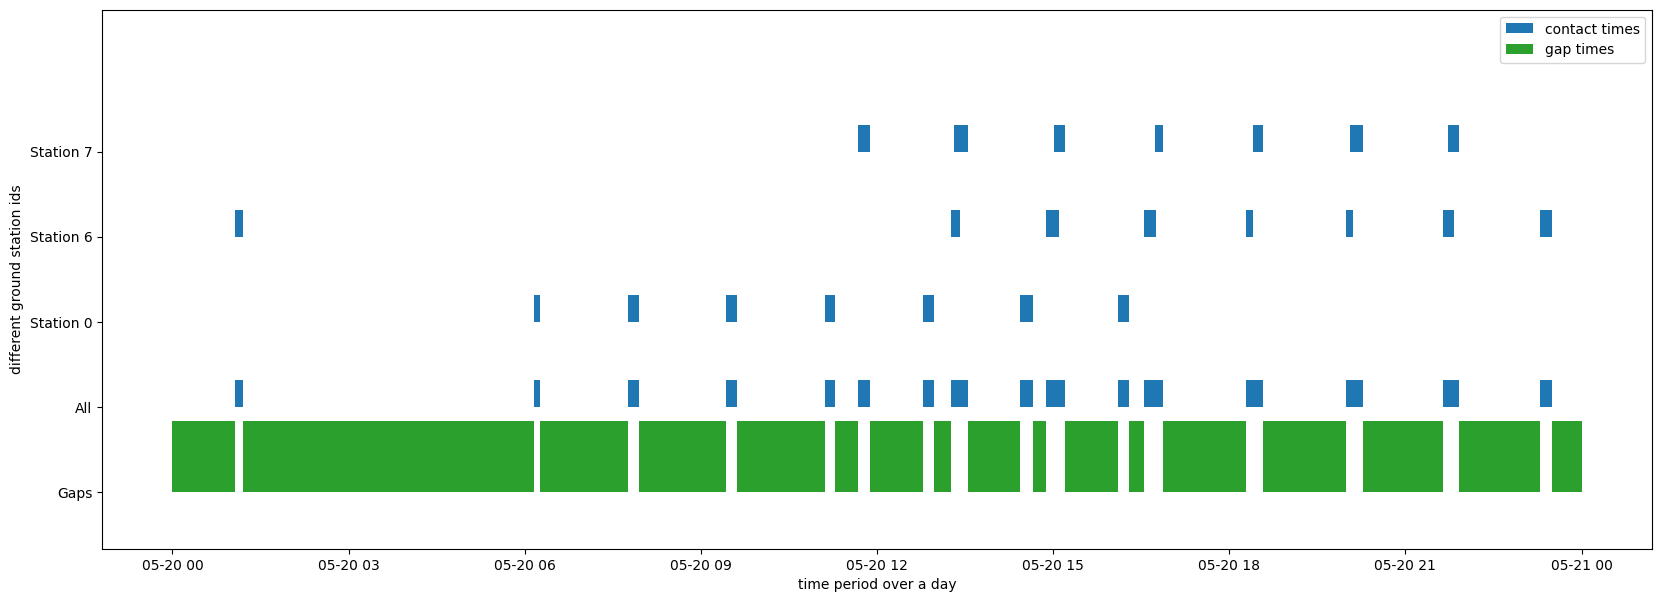

In [12]:
# Visualization
fig, ax = plt.subplots(figsize=(20,7))

selected_station_ids = [i for i in x if x[i].x > 0.5]
contacts_all = []

for idx in range(len(selected_station_ids)):
    station_id = selected_station_ids[idx]
    contacts = station_contacts[station_id]['contacts']
    for contact in contacts:
        contacts_all.append(contact)
    ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start)
                    for contact in contacts],
                    (idx*3, 0.95), facecolors='tab:blue')

ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start)
                for contact in contacts_all],
                (-3, 0.95),
                facecolors='tab:blue',
                label="contact times")

# Use gap_times_condense from utils.py
all_gap_times, gaps_seconds = gap_times_condense(contacts_all, epc0.to_datetime(), epc1.to_datetime())

ax.broken_barh([(gap[0], gap[1]-gap[0]) 
                for gap in all_gap_times],
                (-6, 2.5),
                facecolors='tab:green',
                label="gap times")

ax.set_yticks(range(-6, len(selected_station_ids)*3, 3))
ax.set_yticklabels(['Gaps', 'All'] + [f'Station {sid}' for sid in selected_station_ids])

ax.set_ylim(-8, len(selected_station_ids)*3 + 2)
plt.ylabel("different ground station ids")
plt.xlabel("time period over a day")
plt.legend()
plt.show()

### Draft Gap Minimization Objective Function- does not work currently ###

In [25]:
# Trying new objective function instead of calculating combs
# Create optimization model
model = gp.Model("ground_station_selection")

# Create binary variables for ground station selection
x = {}
station_contacts = {}

# First get all contacts and store them
for i, station in enumerate(ground_stations):
    contacts = ba.find_location_accesses(sat1, station, epc0, epc1)
    station_contacts[i] = {
        'contacts': contacts,
        'station': station
    }
    x[i] = model.addVar(vtype=GRB.BINARY, name=f"station_{i}")

# Add constraint to select exactly MAX_STATIONS ground stations
MAX_STATIONS = 2
model.addConstr(gp.quicksum(x.values()) == MAX_STATIONS, "exact_stations")

def calculate_total_gap(selected_stations):
    """Calculate total gap time for selected stations"""
    # Get all contacts for selected stations
    stations_list = []
    for i in range(len(ground_stations)):
        if selected_stations[i] > 0.5:  # If station is selected
            stations_list.append(station_contacts[i]['station'])
    
    # Use compute_gaps_per_sat to calculate gaps
    if not stations_list:
        return float('inf')  # Penalize invalid solutions
        
    _, _, gaps_seconds = compute_gaps_per_sat([sat1], stations_list, epc0, epc1, plot=False)
    print("selected stations",selected_stations)
    return np.mean(gaps_seconds[0]) if gaps_seconds else float('inf')

# Set objective using lambda
#print("x",x)
#print("stations",[x[0].X])
model.setObjective(lambda: calculate_total_gap([x[i].X for i in x]), GRB.MINIMIZE)

# Set NonConvex parameter to allow nonlinear optimization
model.Params.NonConvex = 2

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found!")
    
    # Get selected stations
    selected_stations = []
    selected_station_objs = []
    for i in x:
        if x[i].x > 0.5:
            selected_stations.append(i)
            selected_station_objs.append(station_contacts[i]['station'])
            print(f"Selected Station {i}")

    # Calculate gaps using compute_gaps_per_sat
    _, all_gap_times, gaps_seconds = compute_gaps_per_sat([sat1], selected_station_objs, epc0, epc1, plot=False)
    
    # Calculate and print total gap time
    total_gap_time = sum(gaps_seconds[0])  # Take first satellite's gaps
    print(f"\nTotal gap time: {total_gap_time:.2f} seconds")
    
    # Print individual gaps
    print("\nGaps between contacts using selected stations:")
    for i, gap_time in enumerate(gaps_seconds[0]):
        print(f"Gap {i+1}: {gap_time:.2f} seconds")

else:
    print("No optimal solution found")

GurobiError: Unable to convert argument to an expression

### Data Downlink Optimization ###



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F82)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 11 columns and 21 nonzeros
Model fingerprint: 0x6270592d
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Presolve removed 2 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 233305 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.333049133200e+05, best bound 2.333049133200e+05, gap 0.0000%

Optimal solution found!
Selected Station 0
Selected Station 1
Selected Station 6
Selected Station 7
Selected Station 9

Data volume per station an

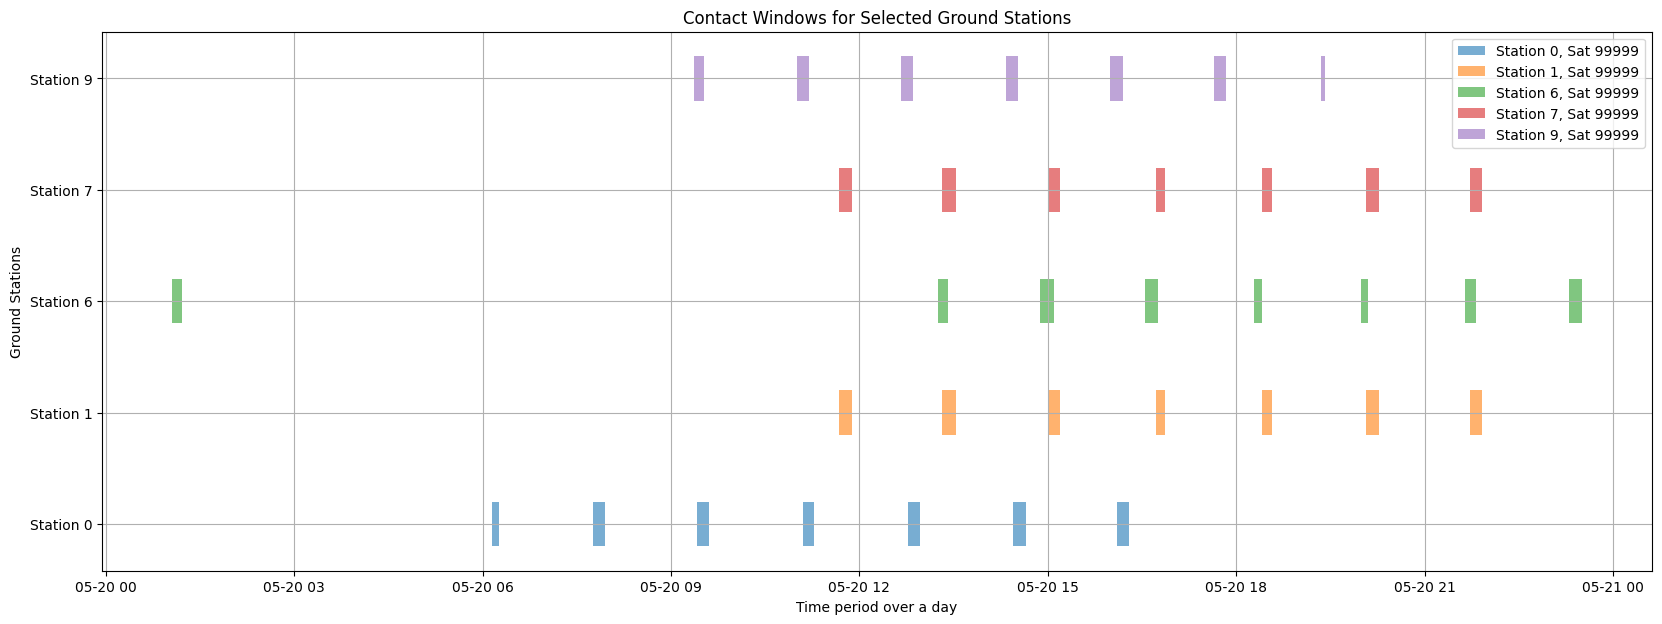

In [13]:
# Create optimization model for maximizing data downlink across multiple satellites
model = gp.Model("ground_station_selection")

# Create binary variables for ground station selection
x = {}
station_contacts = {}

# Create list of satellites
satellites = [sat1]  # Add more satellites to this list as needed

# First get all contacts and store them for each satellite-station pair
for i, station in enumerate(ground_stations):
    station_contacts[i] = {
        'contacts': {},
        'station': station
    }
    for sat in satellites:
        contacts = ba.find_location_accesses(sat, station, epc0, epc1)
        station_contacts[i]['contacts'][sat.id] = contacts
    x[i] = model.addVar(vtype=GRB.BINARY, name=f"station_{i}")

# Add constraint to select exactly MAX_STATIONS ground stations
MAX_STATIONS = 5
model.addConstr(gp.quicksum(x.values()) == MAX_STATIONS, "exact_stations")

# Create variable for total data volume
total_data = model.addVar(name="total_data")

# Calculate data volume for each combination and link to total data
data_constrs = []
for i in x:
    station_data = 0
    # Get contacts for this station for each satellite
    for sat in satellites:
        contacts = station_contacts[i]['contacts'][sat.id]
        
        # Calculate data volume for these contacts
        # Assuming a constant data rate during contact periods
        data_rate = 10  # Mbps (example value)
        sat_station_data = sum((contact.t_end - contact.t_start).total_seconds() * data_rate for contact in contacts)
        station_data += sat_station_data
    
    # When this station is selected, contribute its data volume to total
    data_constrs.append(station_data * x[i])

# Total data is sum of all selected station data volumes
model.addConstr(total_data == gp.quicksum(data_constrs))

# Set objective to maximize total data volume
model.setObjective(total_data, GRB.MAXIMIZE)

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found!")
    
    # Get selected stations
    selected_stations = []
    selected_station_objs = []
    for i in x:
        if x[i].x > 0.5:
            selected_stations.append(i)
            selected_station_objs.append(station_contacts[i]['station'])
            print(f"Selected Station {i}")

    # Calculate total data volume
    total_data_volume = 0
    print("\nData volume per station and satellite:")
    for station_id in selected_stations:
        station_total = 0
        print(f"\nStation {station_id}:")
        for sat in satellites:
            contacts = station_contacts[station_id]['contacts'][sat.id]
            sat_data = sum((contact.t_end - contact.t_start).total_seconds() * data_rate for contact in contacts)
            station_total += sat_data
            print(f"  Satellite {sat.id}: {sat_data:.2f} Megabits")
        print(f"  Station Total: {station_total:.2f} Megabits")
        total_data_volume += station_total
    
    print(f"\nTotal data volume across all selected stations: {total_data_volume:.2f} Megabits")

else:
    print("No optimal solution found")

# Visualization
fig, ax = plt.subplots(figsize=(20,7))

# Plot contacts for each selected station and satellite
plot_offset = 0
for station_idx, station_id in enumerate(selected_stations):
    for sat_idx, sat in enumerate(satellites):
        contacts = station_contacts[station_id]['contacts'][sat.id]
        y_pos = plot_offset + sat_idx
        ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start) 
                        for contact in contacts],
                        (y_pos, 0.8),
                        facecolors=f'C{station_idx}',
                        alpha=0.6,
                        label=f'Station {station_id}, Sat {sat.id}' if sat_idx == 0 else "")
    plot_offset += len(satellites) + 1

ax.set_yticks([i + 0.4 for i in range(0, plot_offset, len(satellites) + 1)])
ax.set_yticklabels([f'Station {sid}' for sid in selected_stations])

plt.ylabel("Ground Stations")
plt.xlabel("Time period over a day")
plt.title("Contact Windows for Selected Ground Stations")
plt.legend()
plt.grid(True)
plt.show()